In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

### Constants

In [2]:
F = 96485 # C / mol
ne_H2 = 2 # mol e / mol H
m_H2 = 2 # g/mol
g_to_kg = 1000
G0 = 237000 # J / mol
H0 = 285000 # J / mol
S0 = 163 # J / mol-K
V_to_eff = 26.8 # conversion factor for hydrogen

In [3]:
### Model assumptions = = = =
## Comment out the variable functions
# System function
replace_rate = 7

MINCELLV = 1.9 #V
MINCELLJ = 1 #A/cm^2
#CELL_COST = 0.1 #$/cm^2

#Operating
ELECTRIC = 0.02# $/kWh
CAPACITY = 0.4

#Durability
#voltage_drift = 1E-6 # V/h
stack_replacement = 0.15 # fraction

# Finances
IRR = 0.10 # fractional rate
INFLATION = 0.019 # fractional rate


### Cell and Stack Design

In [4]:
## Balance of plant
# Reference: https://www.nrel.gov/hydrogen/assets/docs/current-central-pem-electrolysis-v3-2018.xlsm

## Stack model
hydrogen_prod = 50000/24 #kg/h ... 50 tonnes per day divided by 24 hours
max_year = 20

# def bop_model(min_cell_voltage=MINCELLV,cell_J=MINCELLJ,cell_cost=0.2):
#     ## Cell model defaults
#     #====Secondary input====
#     bop_electrical = 5 #kWh/kg
#     min_power = min_cell_voltage * cell_J * total_cell_area / 1000 # kW
#     #====Model input
#     stack_cost = total_cell_area * cell_cost
#     #====
#     power_specific_cost = stack_cost / min_power
    
# #     print()
# #     print("Cell efficiency {0:.1f} kWh/kg".format(min_cell_voltage*V_to_eff))
# #     print("System efficiency {0:.1f} kWh/kg".format(min_cell_voltage*V_to_eff+bop_electrical))
# #     print("Power specific cost ${0:.2f}/kW".format(power_specific_cost))
    
#     return stack_cost, total_cell_area

### Cash flow set up

In [5]:
def system_model(stack_cost, voltage_drift, min_cell_voltage=MINCELLV, cell_J=MINCELLJ, replace_rate=replace_rate, SHOWCOSTS=False):
    #Capital costs
    #====Secondary input====
    bop_electrical = 5 #kWh/kg
    elec_bop_cost = 82 #$/kW
    mech_bop_cost = 76 #$/(kg/day)
    
    cell_prod = cell_J / (ne_H2*F) * (3600 / g_to_kg * m_H2) #kg/h/cm^2
    total_cell_area = hydrogen_prod/cell_prod # cm^2

    maximum_power = (min_cell_voltage + voltage_drift*8760*stack_replacement) * cell_J * total_cell_area / 1000 # kW
    #====Model inputs
    system_cost = stack_cost*maximum_power + elec_bop_cost*maximum_power + mech_bop_cost*hydrogen_prod*24
    #====
    if SHOWCOSTS:
        print()
        print("Total system cost is ${0:.2f} million".format(system_cost/1e6))
        print("Stack:  ${0:.2f} million".format(stack_cost*maximum_power/1e6))
        print("Electrical: ${0:.2f} million".format(elec_bop_cost*maximum_power/1e6))
        print("Mechanical: ${0:.2f} million".format(mech_bop_cost*hydrogen_prod*24/1e6))
        
    return system_cost

In [6]:
system_model(200, 2e-6, SHOWCOSTS=True)


Total system cost is $33.76 million
Stack:  $21.25 million
Electrical: $8.71 million
Mechanical: $3.80 million


33758430.35159723

### Calculate LCOH

In [7]:
def NPV_calc(h2_price, voltage_drift, system_cost, stack_cost, min_cell_V=MINCELLV, show_results=False):
    
   #Scheduled cash flow
    CashFlow = pd.DataFrame({'Years':[],'Stack Life':[],'Inflation Year':[],
                            'Stack Eff':[], 'Hydrogen Sales':[],'Replacement Costs':[],'Operating Costs':[],
                            'Net Cash Flow':[],'Discounted Flow':[]})

    ## Initialize variables
    year = [1]
    stacklife = [0]
    inflationyear = [1]
    stackeff = [0]
    hydrogensales = [0]
    replacement_costs = [0]
    operating_costs = [0]
    net_cash = [-system_cost]
    discounted_cash = [net_cash[-1]/(1+IRR)**year[-1]]

    for x in range(2,max_year+2):
        year.append(x)
        inflationyear.append((1+INFLATION)**x)

        #Hydrogen sales
        hydrogensales.append(h2_price*hydrogen_prod*8760*CAPACITY) # [$/kg] * [kg/h] * [h/year] * percent
        hydrogensales[-1] = hydrogensales[-1]*inflationyear[-1]

        #Stacklife counting
        if year[-1] == (max_year+1): # Don't replace stack in the last year of life
            stacklife.append(stacklife[-1]+1)           
        elif stacklife[-1] < replace_rate:
            stacklife.append(stacklife[-1]+1)
        else:
            stacklife.append(1)

        #Maintenance cost are 0.5% system cost per year + stack replacement
        replacement_costs.append(stack_replacement*system_cost*(stacklife[-1]==replace_rate) + 0.005*system_cost)
        replacement_costs[-1] = replacement_costs[-1]*inflationyear[-1]

        #Stack efficiency is the average of the beginning and end of year efficiency
        try:
            stackeff.append(V_to_eff*(min_cell_voltage + voltage_drift*8760*CAPACITY*(stacklife[-1]+stacklife[-1]-1) / 2) )
        except: 
            stackeff.append(V_to_eff*(MINCELLV + voltage_drift*8760*CAPACITY*(stacklife[-1]+stacklife[-1]-1) / 2) )
            
        #Operating costs are assumed to be dominated by electricity prices
        operating_costs.append(ELECTRIC*stackeff[-1]*hydrogen_prod*8760*CAPACITY) # [$/kWh] * [kWh/kg] * [kg/h] * [h/year] * percent
        operating_costs[-1] = operating_costs[-1]*inflationyear[-1]

        #Net cash flow = Sales - replacement - operating costs
        net_cash.append(hydrogensales[-1] - operating_costs[-1] - replacement_costs[-1])

        #Discounted cash flow = net cash flow / (1+IRR)^year
        discounted_cash.append(net_cash[-1]/(1+IRR)**year[-1])

    CashFlow['Years'] = year
    CashFlow['Stack Life'] = stacklife
    CashFlow['Inflation Year'] = inflationyear
    CashFlow['Stack Eff'] = stackeff
    CashFlow['Hydrogen Sales'] = hydrogensales
    CashFlow['Replacement Costs'] = replacement_costs
    CashFlow['Operating Costs'] = operating_costs
    CashFlow['Net Cash Flow'] = net_cash
    CashFlow['Discounted Flow'] = discounted_cash
    
    if show_results:
        return CashFlow
    else:
        return sum(CashFlow['Discounted Flow'])


In [8]:
def LCOH(durability,stack_cost):
    # BOP function
    # System function
    system_cost = system_model(stack_cost=stack_cost, voltage_drift=durability)

    low_price = 0.10
    high_price = 20
    low_val = NPV_calc(low_price,  voltage_drift=durability,system_cost=system_cost, stack_cost=stack_cost)
    high_val = NPV_calc(high_price,  voltage_drift=durability,system_cost=system_cost, stack_cost=stack_cost);
    
    slope = (high_price - low_price)/(high_val - low_val)
    
#     print()
#     print(" = = = = = = = = = ")
#     print("Electricty price = ${0:0.2f}/kWh".format(ELECTRIC))
#     print("Capacity factor = {0:0.2f}/kWh".format(CAPACITY))
#     print("Stack Voltage = ${0:0.2f}/kWh".format(min_cell_voltage))
#     print("Levelized cost of hydrogen ($/kg) is... ")
    
    return high_price - high_val*slope

### Iterate across LCOH vs model assumptions

Iteratively set up model + build NPV function before running LCOH function to calculate LCOH

In [9]:
## Set up a mesh grid for desired variables
Ds = np.logspace(-1,3,20)
Stacks = np.logspace(1,3.7,20)
XX,YY = np.meshgrid(Ds,Stacks) # syntax is columns, rows
rs, cs = np.shape(XX)
Z = np.zeros((rs,cs))

for row in range(0,len(Stacks)):
    for col in range(0,len(Ds)):
            durability = XX[row,col]*1e-6
            stack_cost = YY[row,col]
            Z[row,col] = LCOH(durability=durability,stack_cost=stack_cost)

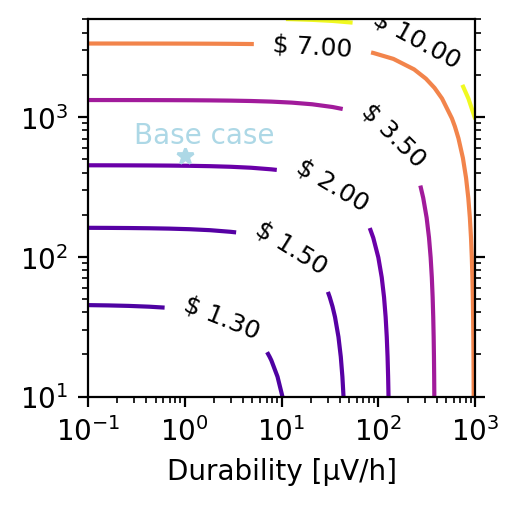

In [22]:
fig, ax = plt.subplots(figsize=(2.5,2.5))
manual_lines = [1.3, 1.5, 2, 3.5, 7, 10]
CS = ax.contour(XX, YY, Z, manual_lines, cmap='plasma', vmin=0, vmax=10)

ax.plot(1, 526,'*',color='lightblue') # Base case
ax.text(0.3,650,'Base case',color='lightblue',rotation=0) # Base case

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Durability [µV/h]')
#ax.set_ylabel('Cell Cost [\$/$cm^2$]')
ax.clabel(CS, inline=True, fontsize=9, colors='k', fmt='$ %1.2f')
# ax.plot(2,1,'b*')
# ax.text(0.3,0.8,'PEM',color='b')
ax.tick_params(right=True, which='both')
plt.gcf().set_dpi(200)

-802087.0617839661

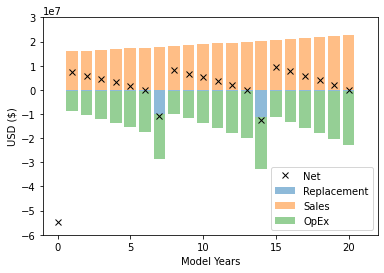

In [11]:
# BOP function
stack_cost = 365
durability = 100e-6
# System function
system_cost = system_model(stack_cost=stack_cost, voltage_drift=durability)

CF = NPV_calc(2.1,  voltage_drift=durability,system_cost=system_cost, stack_cost=stack_cost, show_results=True)
plt.bar(CF['Years']-1,-CF['Replacement Costs'],alpha=0.5)
plt.bar(CF['Years']-1,CF['Hydrogen Sales'],alpha=0.5)
plt.bar(CF['Years']-1,-CF['Operating Costs'],bottom=-CF['Replacement Costs'],alpha=0.5)
plt.plot(CF['Years']-1,CF['Net Cash Flow'],'kx')
plt.legend(['Net','Replacement', 'Sales', 'OpEx'])
plt.ylim([-6e7,3e7])
plt.xlim([-1,22])
plt.xlabel('Model Years')
plt.ylabel('USD ($)')

sum(CF['Net Cash Flow'])

In [12]:
CF.head()

,Years,Stack Life,Inflation Year,Stack Eff,Hydrogen Sales,Replacement Costs,Operating Costs,Net Cash Flow,Discounted Flow
0,1,0,1.000000,0.00000,0.000000e+00,0.000000,0.000000e+00,-5.450129e+07,-4.954663e+07
1,2,1,1.038361,55.61536,1.591807e+07,282960.085080,8.431328e+06,7.203786e+06,5.953542e+06
2,3,2,1.058090,65.00608,1.622052e+07,288336.326697,1.004221e+07,5.889969e+06,4.425221e+06
3,4,3,1.078194,74.39680,1.652871e+07,293814.716904,1.171127e+07,4.523627e+06,3.089698e+06
4,5,4,1.098679,83.78752,1.684275e+07,299397.196525,1.344012e+07,3.103237e+06,1.926866e+06
